## Predicting Stock Price using moving averages/n-number of historical data

For example, as opposed to fitting a linear regression model to all of the historical data provided in the training set, the regression model is fitted only on N number of data points from the past. This showed some good performance in predicting stock prices however, it is challenging to apply on more futuristic test sets outside of window, `N.` 

In [ ]:
#import relevant libraries
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np, math; 
import matplotlib
import pandas_datareader.data as web
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score; 

from matplotlib.pylab import rcParams #setting figure size
rcParams['figure.figsize'] = 20,10

# Plot formatting
%matplotlib inline 
style.use('ggplot')

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

np.warnings.filterwarnings('ignore')

## Create function to extract historical `stock` data using Yahoo finance from a `startdate` to an `enddate`

In [2]:
# download data from Jan, 2010 to Jan 2020
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2020, 1, 1)

# Get stock data 
def get_stock_data(symbol, start=dt.datetime(2010, 1, 1), end=dt.datetime(2020, 1, 1)):
    '''
    download stock data over from yahoo api form start date to end date
    input
        stock - String representing stock symbol eg APPL
        start - datetime object represent start date; default Jan 1, 2010
        end - datetime object represent end date; default: Jan 1, 2020
    output
        historical stock data pulled from yahoo finance stock api from start to end dates
    '''
    stockData = web.DataReader(symbol, 'yahoo', start, end)
    
    return stockData

df_GOOG = get_stock_data('GOOG')
print(df_GOOG.head(5))

                  High         Low        Open       Close      Volume  \
Date                                                                     
2010-01-04  313.579620  310.954468  312.304413  312.204773   3927000.0   
2010-01-05  312.747742  309.609497  312.418976  310.829926   6031900.0   
2010-01-06  311.761444  302.047852  311.761444  302.994293   7987100.0   
2010-01-07  303.861053  295.218445  303.562164  295.940735  12876600.0   
2010-01-08  300.498657  293.455048  294.894653  299.885956   9483900.0   

             Adj Close  
Date                    
2010-01-04  312.204773  
2010-01-05  310.829926  
2010-01-06  302.994293  
2010-01-07  295.940735  
2010-01-08  299.885956  


In [ ]:
def plot_df(df, col, title=None):
    '''
    plot stock information
    input: 
        df - pandas dataframe containing historical stock information 
        col - array of strings: column names in df to plot
        title - title of plot.
    output: None
    '''
    fontsize=16
    if title == None:
        title = 'Daily '
        for c_name in col:
            title += c_name+'-'
        title = title[:-1]+' Prices'
        
    df[col].plot(figsize=(20,8), fontsize=fontsize);
    plt.title(title, fontsize=fontsize+4)
    plt.ylabel("price", fontsize=fontsize+4)
    plt.xlabel("date", fontsize=fontsize+4)
    plt.show()

plot_df(df_GOOG, ['Close','Adj Close'], )

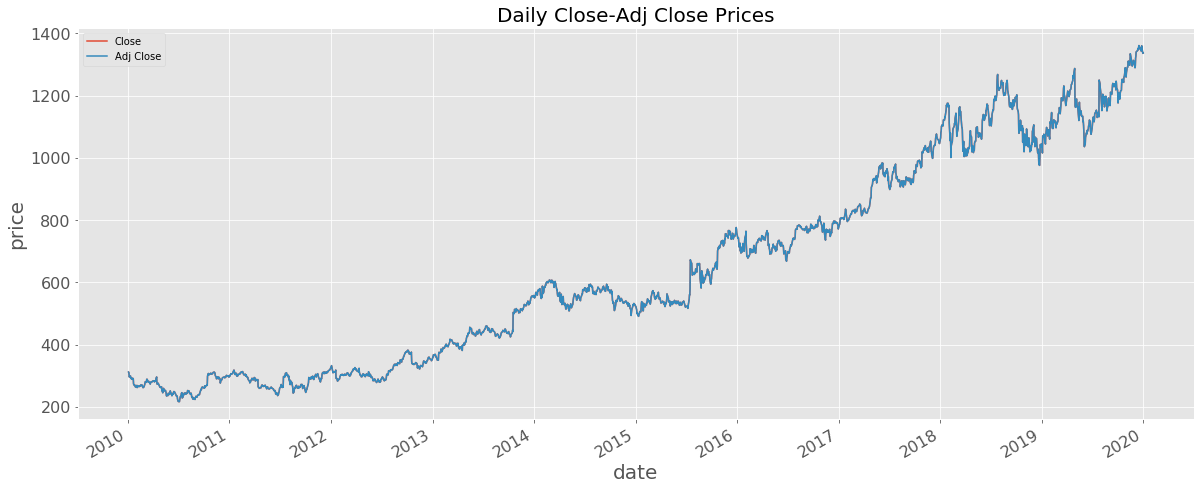

In [3]:
def plot_df(df, col, title=None):
    '''
    plot stock information
    input: 
        df - pandas dataframe containing historical stock information 
        col - array of strings: column names in df to plot
        title - title of plot.
    output: None
    '''
    fontsize=16
    if title == None:
        title = 'Daily '
        for c_name in col:
            title += c_name+'-'
        title = title[:-1]+' Prices'
        
    df[col].plot(figsize=(20,8), fontsize=fontsize);
    plt.title(title, fontsize=fontsize+4)
    plt.ylabel("price", fontsize=fontsize+4)
    plt.xlabel("date", fontsize=fontsize+4)
    plt.show()

plot_df(df_GOOG, ['Close','Adj Close'], )

## Stock Price Prediction
- Using Linear Regression
- Using K-nearest neighbor
- Using Facebook's Prophet

The only features that will be used to predict the stock price are: `‘Year’, ‘Month’, ‘Week’, ‘Day’, ‘Dayofweek’, ‘Dayofyear’, ‘Is_month_end’, ‘Is_month_start’, ‘Is_quarter_end’, ‘Is_quarter_start’,  ‘Is_year_end’, and  ‘Is_year_start’` computed from the trading day. 

In [4]:
#Convert Date column to datetime
def get_features(df):
    '''
    input: 
        df is dataframe of historical stock data where index is the date. 
    output:
        new_df with added features from the day.. 
    '''
    new_df = df[['Adj Close']]
    new_df = new_df.reset_index()
    new_df.columns = ['date','price']
    new_df.loc[:, 'date'] = pd.to_datetime(new_df['date'],format='%Y-%m-%d')
    new_df['year'] = new_df.date.dt.year
    new_df['month'] = new_df.date.dt.month
    new_df['day'] = new_df.date.dt.day
    
    return new_df

dd = get_features(df_GOOG)
print(dd.head(5))

        date       price  year  month  day
0 2010-01-04  312.204773  2010      1    4
1 2010-01-05  310.829926  2010      1    5
2 2010-01-06  302.994293  2010      1    6
3 2010-01-07  295.940735  2010      1    7
4 2010-01-08  299.885956  2010      1    8


In [5]:
def split_train_test(df, cv_size = .2, test_size = .2):
    #Get sizes of each of the datasets
    num_cv = int(cv_size*len(df))
    num_test = int(test_size*len(df))
    num_train = len(df) - num_cv - num_test
    
    print("num_train = " + str(num_train))
    print("num_cv = " + str(num_cv))
    print("num_test = " + str(num_test))

    # Split into train, cv, and test
    train = df[:num_train]
    validation = df[num_train:num_train+num_cv]
    train_cv = df[:num_train+num_cv]
    test = df[num_train+num_cv:]
    
    print("train.shape = " + str(train.shape))
    print("cv.shape = " + str(validation.shape))
    print("train_cv.shape = " + str(train_cv.shape))
    print("test.shape = " + str(test.shape))
    
    return train, validation, train_cv, test

train, validation, train_cv, test = split_train_test(dd)

num_train = 1510
num_cv = 503
num_test = 503
train.shape = (1510, 5)
cv.shape = (503, 5)
train_cv.shape = (2013, 5)
test.shape = (503, 5)


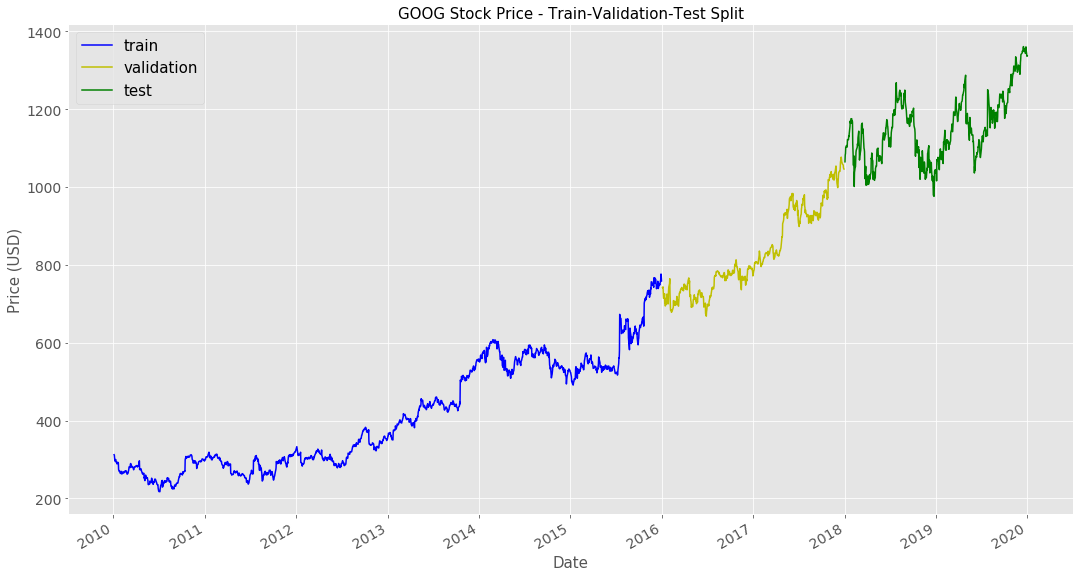

In [6]:
ax = train.plot(x='date', y='price', style='b-', fontsize=14, figsize=(18, 10))
ax = validation.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax.set_title('GOOG Stock Price - Train-Validation-Test Split', fontsize=15)
ax.legend(['train', 'validation', 'test'], fontsize=15)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Price (USD)", fontsize=15);

# Prediction Using Moving Average

In [7]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean()
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # Stock price cannot be zero; set any negative value to zero
    pred_list = np.array(pred_list)
    pred_list[pred_list < 0] = 0
    
    return pred_list[offset:]

def get_mean_abs_err(y_true, y_pred): 
    '''
    returns mean absolute percentage error (MAPE)
    y_true, y_pred: actual and predicted values
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
RMS_err = []; 
Mean_Abs_Err = []; max_n = 25
for k in range(1, max_n): # k is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'price', k, 0, len(train))
    
    validation.loc[:, 'est' + '_k' + str(k)] = est_list
    rmse = math.sqrt(mean_squared_error(est_list, validation['price']))
    RMS_err.append(rmse)
    mae = get_mean_abs_err(validation['price'], est_list)
    Mean_Abs_Err.append(mae)
    print('K={}\t Root mean square error: {}; Mean absolute error: {}'.format(k, rmse, mae))



NameError: name 'N' is not defined

In [ ]:
# Plot RMSE and Mean basolute Error versus number of features, n
plt.figure(figsize=(18, 8), dpi=80)
plt.plot(range(1, max_n), RMS_err, 'x-', linewidth=2, label='Root Mean Square Err')
plt.plot(range(1, max_n), Mean_Abs_Err, label = 'Mean Absolute Error')
plt.xlabel('Num of days to average over'); plt.ylabel('Error')
plt.xlim([2, max_n+1]); plt.title('Error On Validation Set')
plt.xticks([2, 5, 10, 15, 20, 25]);
matplotlib.rcParams.update({'font.size': 14})

## results: 
###  Using Moving Average, the lowest mean square error is achieved when N = 1.

### Price prediction using Linear Regression
Linear regression models seek to find a linear relationship between the independent variables and the dependent variable.

In [ ]:
def get_preds_lin_reg(train, test, target_col, N):
    """
    Given a dataframe, get prediction at each timestep
    Inputs
        df         : dataframe with the values you want to predict     
        target_col : name of the column you want to predict
        N          : use previous N values to do prediction
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]
    Outputs
        pred_list  : the predictions for target_col
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)
    pred_list = []
    for i in range():
        x_train = np.array(train.drop('target_col'))
        y_train = np.array(train['traget_col'])
        regr.fit(X_train, y_train)            # Train the model
        pred_list = regr.predict(N)
    
        #pred_list.append(pred[0][0])  
    
    # Price cannot be negative, set negative values to 0
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = 0
        
    return pred_list

In [ ]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df[target_col])):
        X_train = np.array(range(len(df[target_col][i-N:i]))) # e.g. [0 1 2 3 4]
        y_train = np.array(df[target_col][i-N:i]) # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
        # X_train = np.c_[np.ones(N), X_train]              # add a column
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  # Predict the footfall using the model
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

In [ ]:
RMSE = []
R2 = []
mape = []
cv = validation; Nmax = 25
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'price', N, 0, len(train))
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['price'])))
    R2.append(r2_score(cv['price'], est_list))
    mape.append(get_mean_abs_err(cv['price'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
validation.head()

In [ ]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

In [ ]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [ ]:
N_opt = 5
est_list = get_preds_lin_reg(dd, 'price', N_opt, 0, len(train_cv))
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['price'])))
print("R2 = %0.3f" % r2_score(test['price'], est_list))
print("MAPE = %0.3f%%" % get_mean_abs_err(test['price'], est_list))
test.head()

In [ ]:
ax = test.plot(x='date', y='price', style='gx-', grid=True)

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='price', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['Actual values', 'predictions using linear regression'], loc='upper left')
ax.set_title('Performance on Test Set')
ax.set_xlabel("date")
ax.set_ylabel("USD")

## Findings
On the dev set, the lowest RMSE is 1.2 which is achieved using N=1, ie. using value on day t-1 to predict value on day t
On the dev set, the next lowest RMSE is 1.36 which is achieved using N=5, ie. using values from days t-5 to t-1 to predict value on day t
We will use N_opt=5 in this work since our aim here is to use linear regression
On the test set, the RMSE is 1.42 and MAPE is 0.707% using N_opt=5

## Facebook's Prophet Method

Prophet follows the sklearn model API. Prophet can make forecasts for time series with sub-daily observations by passing in a dataframe with timestamps in the ds column. The format of the timestamps should be YYYY-MM-DD HH:MM:SS - see the example csv here. When sub-daily data are used, daily seasonality will automatically be fit. [link to documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

In [ ]:
train.rename(columns={'price': 'y', 'date': 'ds'}, inplace=True)
test.rename(columns={'price': 'y', 'date': 'ds'}, inplace=True)
test.head(5)

In [ ]:
### Unfortunaty, Prophet is not yet compatible with Python 3.8. 